<center><h1> South German Credit </h1></center

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('SouthGermanCredit.asc', sep=' ')
data.columns = ['status','duration','credit_history','purpose','amount','savings','employment_duration','installment_rate','personal_status_sex','other_debtors','present_residence','property','age','other_installment_plans','housing','number_credits','job','people_liable','telephone','foreign_worker','credit_risk']
data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


## Pre-Processing

In [4]:
X = data.iloc[:,:20]
y = data['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=3)

over_sample = SMOTE(random_state=2)
attributes = X_train.columns
smote_X, smote_y = over_sample.fit_resample(X_train, y_train)

smote_x = pd.DataFrame(data=smote_X, columns=attributes)
smote_y = pd.DataFrame(data=smote_y, columns=['credit_risk'])

print(len(smote_y[smote_y['credit_risk']==0]),len(smote_y[smote_y['credit_risk']==1]))

486 486


# Model Development

## Building the model

With the issue of imbalanced classes addressed using SMOTE, our next step involves Recursive Feature Elimination (RFE) to select independent variables based on their impact on the logistic regression model with Credit Risk as the target variable.

However, it's important to note that even with this feature selection technique, we anticipate that the resulting variables may not necessarily lead to a highly predictive model. This expectation is driven by our earlier observation, which revealed the lack of statistically significant correlations between the independent variables and the target variable.

Having completed the RFE procedure and identified the variables with the most substantial impact, we can now proceed to build our logistic regression model. Subsequently, we present a set of evaluation metrics and their respective values for the model we have constructed.

To begin, we have constructed the Confusion Matrix, which allows us to categorize our predictions as follows:

- Correctly classified 227 observations.
- Incorrectly classified 65 observations.

This matrix provides insights into the model's performance, particularly its ability to correctly predict the class labels, while highlighting areas where improvements may be necessary.

In [5]:
features = data.columns.values.tolist()
y = ['credit_risk']
X = [i for i in features if i not in y]

model_log = LogisticRegression(max_iter=10000)
model_rfe = RFE(model_log, step=2)

model_rfe.fit(smote_x, smote_y.values.ravel())
smote_x.drop(smote_x.columns[np.where(model_rfe.support_==False)[0]], axis=1, inplace=True)

In [6]:
X=smote_x
y=smote_y['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
model_log = LogisticRegression(max_iter=10000)
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

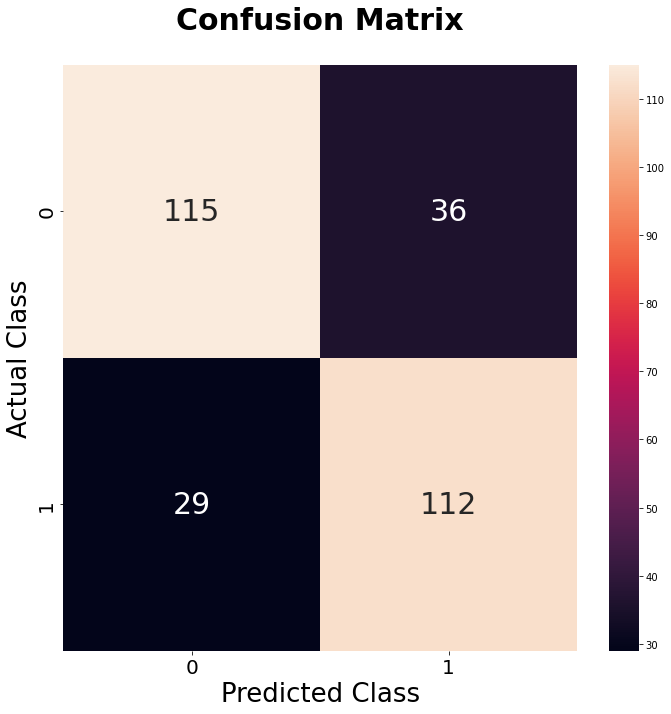

In [7]:
cnfs_mat = confusion_matrix(y_test,y_pred)

plt.rcParams["figure.figsize"]=(10,10)
sns.heatmap(cnfs_mat, annot=True, fmt="g", annot_kws={'size': 30})
plt.title('Confusion Matrix', fontsize=30, y=1.05, weight='bold')
plt.xlabel('Predicted Class', fontsize=26)
plt.ylabel('Actual Class', fontsize=26)
plt.xticks(size=20)
plt.yticks(size=20)
plt.tight_layout()

# Model Evaluation

Following the Confusion Matrix, we provide a table displaying various model evaluation metrics, including precision, recall, f1-score, and support, as detailed below:

In [8]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       151
           1       0.76      0.79      0.78       141

    accuracy                           0.78       292
   macro avg       0.78      0.78      0.78       292
weighted avg       0.78      0.78      0.78       292



In [9]:
model_roc_auc = roc_auc_score(y_test, model_log.predict(X_test))
model_roc_auc

0.7779578225541308

Additionally, we calculated the Area Under the Curve (AUC) for the ROC curve, and the resulting value is approximately 0.77. We have also created a graphical representation of the ROC curve.

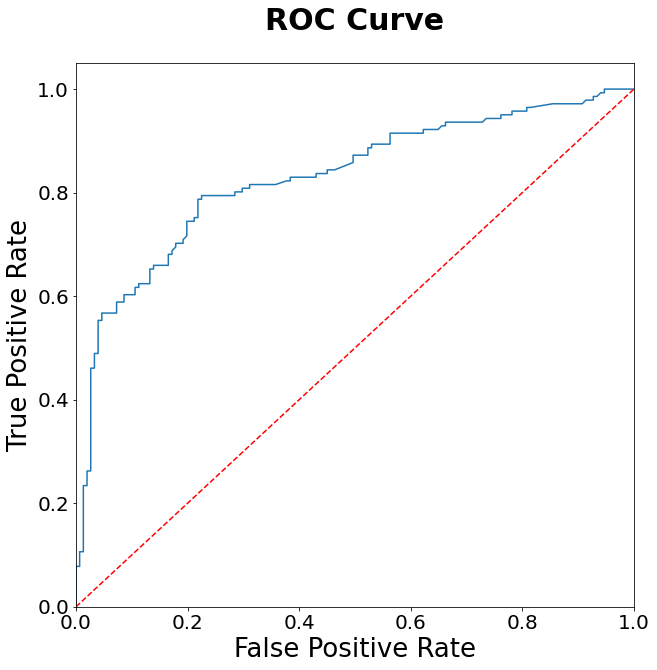

In [10]:
fp_rate, tp_rate, lim = roc_curve(y_test, model_log.predict_proba(X_test)[:,1])

plt.rcParams["figure.figsize"]=(10,10)
plt.plot(fp_rate,tp_rate, label='area = %0.2f'% model_roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize=26)
plt.ylabel('True Positive Rate', fontsize=26)
plt.title('ROC Curve', fontsize=30, y=1.05, weight='bold')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

For a comprehensive model evaluation, we conducted Repeated K-Fold Cross-Validation and estimated key metrics, including accuracy, precision, recall, and F1-score, with the following results:

In [11]:
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
scores = cross_val_score(model_log, X, y, scoring='accuracy', cv=cross_val, n_jobs=-1)
print('Accuracy: mean: %.3f std: %.3f' % (np.mean(scores), np.std(scores)))

Accuracy: mean: 0.752 std: 0.040


In [12]:
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
scores_accuracy = cross_val_score(model_log, X, y, scoring = 'accuracy', cv=cross_val, n_jobs=-1)
scores_precision = cross_val_score(model_log, X, y, scoring = 'precision', cv=cross_val, n_jobs=-1)
scores_recall = cross_val_score(model_log, X, y, scoring = 'recall', cv=cross_val, n_jobs=-1)
scores_f1_score = cross_val_score(model_log, X, y, scoring = 'f1', cv=cross_val, n_jobs=-1)
print(f"Achieved mean accuracy of {np.mean(scores_accuracy):.4f} with std of {np.std(scores_accuracy):.4f}.")
print(f"Achieved mean precision of {np.mean(scores_precision):.4f} with std of {np.std(scores_precision):.4f}.")
print(f"Achieved mean recall of {np.mean(scores_recall):.4f} with std of {np.std(scores_recall):.4f}.")
print(f"Achieved mean f1-score of {np.mean(scores_f1_score):.4f} with std of {np.std(scores_f1_score):.4f}.")

Achieved mean accuracy of 0.7518 with std of 0.0401.
Achieved mean precision of 0.7609 with std of 0.0590.
Achieved mean recall of 0.7362 with std of 0.0594.
Achieved mean f1-score of 0.7463 with std of 0.0450.


The model accurately classifies approximately 75.18% of the observations with a precision rate of 76.09%.